In [161]:
using LinearAlgebra
using Plots
using SparseArrays
using Arpack #Eigenvalues of sparse arrays with eigs()
using DifferentialEquations
using DiffEqFlux
using Optim
# using StaticArrays

In [68]:
#Def parameters
n_cutoff = 8
N = 2 * n_cutoff + 1
n = sparse(Diagonal(LinRange(-n_cutoff, n_cutoff, N))) #Perhaps implement using StaticArrays
Id = sparse(I, N, N)
exp_iPhi = spdiagm(-1 => ones(N - 1));

#Def Hamiltonian parameters
E_J_GHz = 10.0 #scale of E_J in units of h*GHz, h-bar = 1, h = 2pi
E_C = 1/100  #Charging energies
E_J = 1.0 #Josephson energies
phi_ext = 0.995pi;

prefactor = 4 * E_C
Kinetic = 2pi * E_J_GHz * prefactor * (kron(n^2, Id) .+ kron(Id, n^2))

Potential1 = -2pi * E_J_GHz * kron(1 / 2 * (exp_iPhi .+ exp_iPhi'), Id) # -E_J1 cos(phi1)
Potential2 = -2pi * E_J_GHz * kron(Id, 1 / 2 * (exp_iPhi .+ exp_iPhi')) # -E_J2 cos(phi2)
Potential3 = -2pi * E_J_GHz * E_J / 2 * (exp(im * phi_ext) * kron(exp_iPhi, exp_iPhi') .+ exp(-im * phi_ext) * kron(exp_iPhi', exp_iPhi)) #-E_J3 cos(phi1 - phi2 + phi_ext)
Potential12 = E_J * (Potential1 .+ Potential2)
KinPot12 = Kinetic .+ Potential12
chargecoupling = kron(n, Id);

In [199]:
qubit_freq = 2.4825403959499113
level = 0.7
decline_end = 10.0
ascend_start = 20.0
function alpha(p, t)
    if t < decline_end
        return 1 - (1 - level) / decline_end * t
    elseif t > ascend_start
        return level + (1 - level) / decline_end * (t - ascend_start)
    else
        return level
    end
end

# Tpulse = 10.0
phase_offset = 0.0pi
freq_scale = 1.0#- 1e-1*(-0.0027936870890755317)
# tspan = ()
t_ramp = 2.0
function pulse(p, t)
    if decline_end < t < decline_end + t_ramp
        amp = sin(pi / 2 * (t - decline_end) / t_ramp)^2
    elseif decline_end + t_ramp <= t <= ascend_start - t_ramp
        amp = 1
    elseif ascend_start - t_ramp < t < ascend_start
        amp = sin(pi / 2 * (ascend_start - t) / t_ramp)^2
    else
        amp = 0
    end
    amp *= 1.3314045280692275
    return amp * cos(p[1] * qubit_freq * (t - decline_end) + phase_offset)
end

function H_int(u, p, t)
    H = KinPot12 + alpha(u, p, t) * Potential3
    V = pulse(u, p, t) * chargecoupling
    return - im * (H + V) * u
end

function H_int!(du, u, p, t)
    H = KinPot12 + alpha(p, t) * Potential3
    V = pulse(p, t) * chargecoupling
    du[:] = - im * (H + V) * u
end

H_int! (generic function with 1 method)

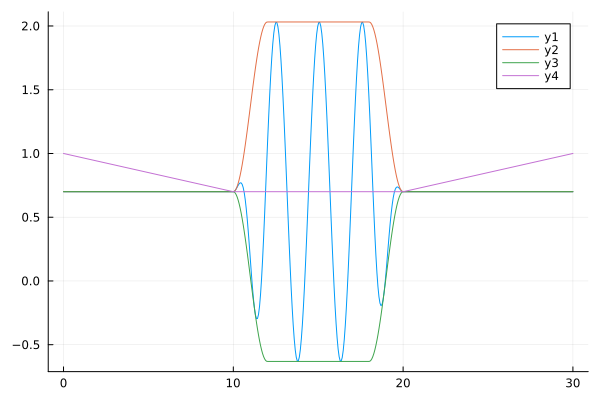

In [200]:
times = LinRange(0,30, 500)
plot(times, [[pulse([freq_scale],t) for t in times].+0.7,
             [pulse([0.0],t) for t in times].+0.7,
             [-pulse([0.0],t) for t in times].+0.7,
             [alpha(nothing,t) for t in times]])

In [201]:
Es, ψs = eigs(KinPot12 + Potential3, nev=2, which=:SR, ncv = 100,maxiter=1000);

In [207]:
p = [freq_scale]
forward_prob = ODEProblem(H_int!, ψs[:,1:2], (0.0, 30.0), p);

In [208]:
solution = solve(forward_prob,p=p, saveat=30.0, reltol=1e-12, abstol=1e-15)

retcode: Success
Interpolation: 1st order linear
t: 2-element Vector{Float64}:
  0.0
 30.0
u: 2-element Vector{Matrix{ComplexF64}}:
 [-4.042601321319322e-10 - 6.267827299355961e-10im 4.370072982057479e-10 + 5.678481123876779e-10im; -4.600791104895696e-9 - 2.6850925152564488e-9im 8.372416234666529e-10 + 5.0919340894696325e-9im; … ; -5.485614723186182e-10 - 5.2986866387731815e-9im 4.707753202169348e-9 + 2.113249658410063e-9im; -4.0426047319168367e-10 - 6.267825000694331e-10im 4.3700680015446537e-10 + 5.678482027642016e-10im]
 [4.198216298722323e-10 - 5.823243756028783e-10im 1.9995141352508952e-10 - 7.125540571541426e-10im; 5.045770751935225e-9 - 2.699697372251926e-9im -1.090305512757695e-9 - 4.64387196967609e-9im; … ; 5.211326677847483e-10 - 4.537913498651538e-9im 3.866583158707534e-9 - 4.6439414903096755e-9im; 4.673568608128e-10 - 5.626287332680671e-10im 2.3051229120688624e-10 - 7.231635677860361e-10im]

In [212]:
abs2.(ψs'*solution[end])

2×2 Matrix{Float64}:
 0.0178431  0.982123
 0.98211    0.0178487

In [203]:
NHilbert = 289

function dpulsedp(p, t)
    if decline_end < t < decline_end + t_ramp
        amp = sin(pi / 2 * (t - decline_end) / t_ramp)^2
    elseif decline_end + t_ramp <= t <= ascend_start - t_ramp
        amp = 1
    elseif ascend_start - t_ramp < t < ascend_start
        amp = sin(pi / 2 * (ascend_start - t) / t_ramp)^2
    else
        amp = 0
    end
    amp *= 1.3314045280692275
    return - amp * qubit_freq * (t - decline_end) * sin(p[1] * qubit_freq * (t - decline_end) + phase_offset)
end

function augmented_H_int!(du, u, p, t)
    H = KinPot12 + alpha(p, t) * Potential3
    V = chargecoupling
    hamil = H + pulse(p, t) .* V
    du[1:NHilbert] = im .* reshape(u[1:NHilbert],(1,:)) * hamil
    du[NHilbert+1:end-1] = -im .* hamil *u[NHilbert+1:end-1]
    du[end] = 2*real(- reshape(u[1:NHilbert],(1,:))*(- im .* V * u[NHilbert+1:end-1])*dpulsedp(p, t))[1]
    return nothing
end

augmented_H_int! (generic function with 1 method)

In [204]:
function calculate_common!(p, last_p, buffer)
    if p != last_p
        copy!(last_p, p)
        sol = solve(forward_prob, p=p, saveat=30.0, reltol=1e-12, abstol=1e-15)
        buffer[:] = sol.u[end]
    end
end

function loss(state)
    1 - abs2(ψs[:,2]'*state)
end

function f(p, buffer, last_p)
    calculate_common!(p, last_p, buffer)
    loss(buffer)
end

function g!(p, storage, buffer, last_p)
    calculate_common!(p, last_p, buffer)
    ψT = copy(buffer)
    a = - dropdims(ψT'*ψs[:,2]*ψs[:,2]',dims=1)
    u0_aug = cat(a,ψT,zeros(Float64,size(p)[1]),dims=1)

    aug_prob = ODEProblem(augmented_H_int!, u0_aug, (30.0,0.0), p);
    aug_sol = solve(aug_prob, p=p, save_everystep=false, reltol=1e-12, abstol=1e-15)
    
    storage[1] = real(aug_sol.u[end][end])
end
    

g! (generic function with 1 method)

In [205]:
initial_p = copy(p)
buffer = zeros(ComplexF64,NHilbert)
last_p = similar(initial_p) .-1
# df = TwiceDifferentiable(p -> f(p, buffer, initial_p), (storage, p) -> g!(p, storage, buffer, last_p))

res = optimize(p -> f(p, buffer, initial_p),
               (storage, p) -> g!(p, storage, buffer, last_p),
               initial_p,BFGS()) #LBFGS

 * Status: success

 * Candidate solution
    Final objective value:     1.207845e-04

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 1.51e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.54e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.38e-13 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 6.11e-09 ≰ 0.0e+00
    |g(x)|                 = 2.37e-12 ≤ 1.0e-08

 * Work counters
    Seconds run:   789  (vs limit Inf)
    Iterations:    3
    f(x) calls:    14
    ∇f(x) calls:   14


In [206]:
Optim.minimizer(res)

1-element Vector{Float64}:
 0.9781204940481706

In [148]:
minimum = Optim.minimizer(res)
minimum[1] - (1 - 0.022)

0.00012049397111557614

In [198]:
Optim.minimizer(res)

1-element Vector{Float64}:
 0.9781204939711156

In [147]:
function calc_loss(p)
    sol = solve(forward_prob, p=p, saveat=30.0, reltol=1e-12, abstol=1e-15)
    return 1 - abs2(ψs[:,2]'*sol.u[end])
end

ps = LinRange(minimum[1] - 10^-5,minimum[1] + 10^-5,3)
out = zeros(Float64,length(ps))
@time for i = 1:length(ps)
    out[i] = calc_loss(ps[i])
end

 48.510507 seconds (27.12 M allocations: 69.041 GiB, 18.24% gc time, 0.64% compilation time: 93% of which was recompilation)


-2.0095036745806786e-9

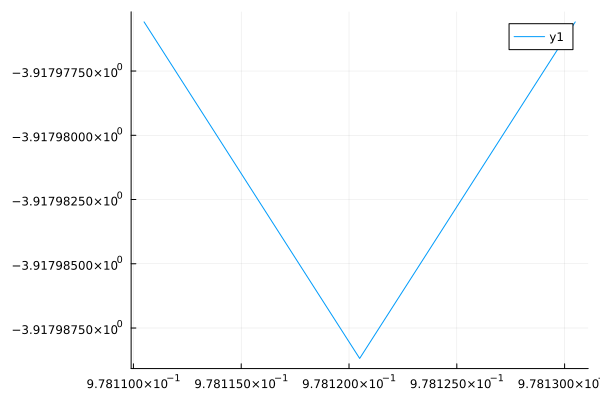

In [149]:
print((out[3] - out[1])/(2*(ps[2]-ps[1])))
plot(ps,log10.(out))

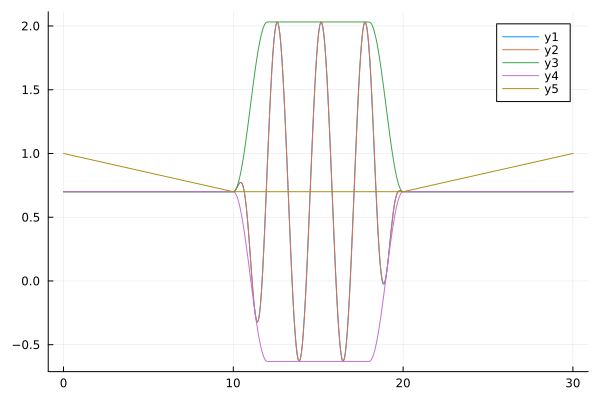

In [150]:
times = LinRange(0,30, 500)
plot(times, [[pulse([freq_scale],t) for t in times].+0.7,
             [pulse(minimum,t) for t in times].+0.7,
            #  [dpulsedp([freq_scale],t) for t in times].+0.7,
             [pulse([0.0],t) for t in times].+0.7,
             [-pulse([0.0],t) for t in times].+0.7,
             [alpha(nothing,t) for t in times]])